У нас есть датасет, содержащий в себе сессии сбора данных Озона за 1 мес. в категории “компьютеры и комплектующие”.
<br>
Сессия представляет из себя сбор различных параметров продукта (id - id товара, title - наименование). 
<br>
Возможны выбросы, неполнота данных, некорректные значения
<br>
https://disk.yandex.ru/d/QlOTpva6Wa4eQw

Нам необходимо:
1. Рассчитать продажи за день по каждому товару
2. Выявить топ 10 брендов по выручке, топ 10 продаваемых товаров
3. Выявить топ товаров, приносящих 80% выручки
4. Построить график продаж
5. Оценить качество данных
6. Объяснить полученную картину:
•	падения и пики на графике продаж
•	как можно улучшить расчет продаж на текущих данных?


Будем следовать плану:
- [ознакомимся с данными](#1)
- [займемся их предобработкой: приведем типы, обработаем дубликаты, заполним пропуски, проверим на адекватность](#2)
- [добавим необходимые данные и рассчитаем цифры, проведем исследовательский анализ](#3)
- [сформулируем выводы](#4)

## Знакомство с данными
<a id='1'></a>

Загрузим нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
from scipy.stats import norm


Прочитаем файл

In [2]:
df = pd.read_csv('C:\\Users\\Александр\Datasets/test_rb.csv', sep='\~')


Глянем на исходную информацию

In [3]:
df.head()

,Unnamed: 0,time,id,title,brand_id,brand_name,price_base,price_final,price_discount,rating_value,...,is_adult,is_alcohol,is_supermarket,is_personalized,is_promoted_product,is_new,is_bestseller,in_stock,session_id,data_source
0,0,2021-07-27 23:03:10+03:00,285756024,Выносная GSM антенна 3 дБ SMA-male,0,NaN,450.0,450,0.00,0.0,...,0,0,0,0,0,0,0,99,1627415787,python-v2.0
1,1,2021-07-27 13:14:12+03:00,292298787,Комплект усиления сотовой связи 3G KRD-2100,0,NaN,10500.0,10500,0.00,0.0,...,0,0,0,0,0,0,0,100,1627380561,python-v2.0
2,2,2021-07-27 09:59:46+03:00,290716134,Wi-Fi роутер Zyxel Nbg6615,0,NaN,5802.0,5046,0.13,0.0,...,0,0,0,0,0,0,0,1,1627367524,python-v2.0
3,3,2021-07-27 13:14:10+03:00,290716175,Wi-Fi роутер Zyxel Armor z2 nbg6817,0,NaN,22747.0,19780,0.13,0.0,...,0,0,0,0,0,0,0,1,1627380561,python-v2.0
4,4,2021-07-27 09:59:46+03:00,290716634,Wi-Fi роутер Tenda U9,0,NaN,2579.0,2243,0.13,0.0,...,0,0,0,0,0,0,0,1,1627367524,python-v2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074749 entries, 0 to 1074748
Data columns (total 38 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1074749 non-null  int64  
 1   time                  1074749 non-null  object 
 2   id                    1074749 non-null  int64  
 3   title                 1074749 non-null  object 
 4   brand_id              1074749 non-null  int64  
 5   brand_name            989293 non-null   object 
 6   price_base            1074749 non-null  float64
 7   price_final           1074749 non-null  int64  
 8   price_discount        1074749 non-null  float64
 9   rating_value          1074749 non-null  float64
 10  rating_count          1074749 non-null  int64  
 11  index                 1074749 non-null  int64  
 12  page_number           1074749 non-null  int64  
 13  search_filter         1074749 non-null  object 
 14  category_id           1074749 non-

Столбцов много: есть подозрение, что бОльшая часть нам в будущем не понадобится - тогда их и отфильтруем

## Предобработка данных
<a id='2'></a>

### Приведение типов

Сразу бросается в глаза, что столбец time - не временного формата. Исправим это

In [5]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

Все остальные типы данных нас устраивают

### Обработка дубликатов

Сначала проверим на полные дубликаты: есть ли у нас полностью повторяющиеся строки. Думается, что дубликаты могут быть во всех столбцах (один товар в разные дни, одинаковая цена у разных товаров, один продавец и тд.), но полных быть не должно.

In [6]:
df.duplicated().sum()

0

Еще может быть вариант, когда под одним id находятся разные наименования title. Проверим это

In [7]:
df.groupby('id')['title'].nunique().reset_index().query('title > 1').sort_values(by='title', ascending=False).head()

,id,title
9719,260672429,6
4711,220916385,5
3101,202621999,5
2990,201279113,5
19507,283443607,4


Таких немало, но критичнны ли они? Возьмем один из примеров

In [8]:
df.query('id == 283443607')['title'].unique()

array(['Модем Huawei E3372h-320 (Wifire)',
       'Модем 4G /3G HUAWEI e3372h-320, черный. Поддержка всех операторов связи.',
       'Модем Huawei e3372-v.320',
       '4G модем Huawei e3372h-320 под всех операторов + сим безлимит '],
      dtype=object)

Как видим, под разным id могут скрываться разные наименования, но по факту товар - один и тот же. 
<br>
Если бы мы были владельцами Озона, то можно было рассмотреть вариант с унификацией описания товаров, чтобы у каждого продавца поля для заполнения были одинаковы и id соответствовали title.

### Пропуски

В нашем датасете мы наблюдаем пропуски только в двух столбцах: brand_name и seller_name. Но у обоих этих столбцов должны быть эквиваленты - brand_id и seller_id. Посмотрим, сможем ли мы заполнить пропуски соответствующими значениями: взглянем на фрейм, в котором название бренда пусто

In [9]:
df[df['brand_name'].isna()].head()

,Unnamed: 0,time,id,title,brand_id,brand_name,price_base,price_final,price_discount,rating_value,...,is_adult,is_alcohol,is_supermarket,is_personalized,is_promoted_product,is_new,is_bestseller,in_stock,session_id,data_source
0,0,2021-07-27 23:03:10+03:00,285756024,Выносная GSM антенна 3 дБ SMA-male,0,NaN,450.0,450,0.00,0.0,...,0,0,0,0,0,0,0,99,1627415787,python-v2.0
1,1,2021-07-27 13:14:12+03:00,292298787,Комплект усиления сотовой связи 3G KRD-2100,0,NaN,10500.0,10500,0.00,0.0,...,0,0,0,0,0,0,0,100,1627380561,python-v2.0
2,2,2021-07-27 09:59:46+03:00,290716134,Wi-Fi роутер Zyxel Nbg6615,0,NaN,5802.0,5046,0.13,0.0,...,0,0,0,0,0,0,0,1,1627367524,python-v2.0
3,3,2021-07-27 13:14:10+03:00,290716175,Wi-Fi роутер Zyxel Armor z2 nbg6817,0,NaN,22747.0,19780,0.13,0.0,...,0,0,0,0,0,0,0,1,1627380561,python-v2.0
4,4,2021-07-27 09:59:46+03:00,290716634,Wi-Fi роутер Tenda U9,0,NaN,2579.0,2243,0.13,0.0,...,0,0,0,0,0,0,0,1,1627367524,python-v2.0


При условии пустых значений в столбце brand_name в столбце brand_id есть нулевые значения - только ли нулевые там?

In [10]:
df[df['brand_name'].isna()]['brand_id'].unique()

array([0], dtype=int64)

Да. А при условии нулевых значений в столбце brand_id есть есть ли заполненные ячейки в столбце brand_id?

In [11]:
df.query('brand_id == 0')['brand_name'].unique()

array([nan], dtype=object)

Нет, но на всякий случай проверим еще по столбцу title. Найдем количестов всех уникальных наименований товаров при условии, что название бренда не определено, и проранжируем их по убыванию

In [12]:
df[df['brand_name'].isna()]['title'].value_counts().head(10)

SIM-карта, Тариф для модема (Вся Россия)                                                           683
Адаптер Bluetooth-AUX, компактный, черный.                                                         558
Автомобильный Bluetooth ресивер адаптер AUX hands free. T0897                                      554
Компактный роутер 4G Wi Fi роутер модем с симкартой                                                541
Переходник кабель UA14 Lightning to HDMI, черный                                                   471
Компактный роутер MQ531                                                                            431
Беспроводной адаптер Wi-Fi USB до 300 МБИТ/С                                                       425
Беспроводной аудио Bluetooth 5,0 приемник передатчик 3,5 мм разъем адаптер для ПК, RCA, ТВ, AUX    413
Bluetooth адаптер USB/Блютуз адаптер 5.0                                                           408
Проигрыватель Bluetooth с AUX выходом для автомобиля                     

И посмотрим, продает ли кто из именованных брендов самый популярный выше товар - SIM-карту

In [13]:
df.query('title == "SIM-карта, Тариф для модема (Вся Россия)"')['brand_id'].unique()

array([0], dtype=int64)

Тоже нет. Так что у нас нет оснований заполнить пропуски в названии бренда в зависимости от других полей. 

Проведем аналогичную работу в отношении столбца seller_name.

In [14]:
df[df['seller_name'].isna()]['seller_id'].unique()

array([180758, 126128, 186373, 161699, 179026, 174394, 188872, 189136,
       182352, 185658, 184391, 182985, 184363, 174960, 183454, 170366,
       172630, 114465, 184946, 185842, 183206, 180003, 179039, 187750,
       160003, 182126, 180315, 182121, 146608, 185466, 187883, 165981,
       171356, 191095, 188547, 186409, 189166, 188591, 126025, 189132,
       190554, 184342, 171852, 137076, 181054, 180412, 174632, 180555,
       166098, 178239, 186168], dtype=int64)

Видим, что в данном случае немало уникальных продавцов (seller_id) являются безымянными (seller_name). И также проверим в обратную сторону: есть ли среди безымянных продавцов те, кто имеет свой идентификатор. Для это создадим список из безымянных продавцов и посмотрим, есть ли хоть у кого из них свой уникальный номер

In [15]:
# создаем список безымянных продавцов
listt = df[df['seller_name'].isna()]['seller_id'].unique()

In [16]:
df.query('seller_id in @listt')['seller_name'].unique()

array([nan], dtype=object)

Аналогичная картина: оснований для заполнения пропусков в seller_name у нас нет

### Проверка данных на адекватность и подготовка итогового фрейма

Чтобы в дальнейшем рассчитать продажи за день, добавим столбец 'day' и 'hour' которые будут отвечать за конкретный день и час сессии. А чтобы сократить время выполнения операций, урежем наш датасет до тех столбцов, которые нам понадобятся в будущем. 

In [17]:
# урезаем датасет
data = df [['time', 'id', 'title', 'brand_id', 'brand_name', 'price_base', 'price_final', 'price_discount', 'seller_id', 'seller_name', 'in_stock']]

In [18]:
# добавляем столбцы
data['day'] = data['time'].dt.day
data['hour'] = data['time'].dt.hour

И для удобства чуть поменяем столбцы местами

In [19]:
columns_titles = ['time', 'day', 'hour', 'id', 'title', 'brand_id', 'brand_name', 'price_base', 'price_final', 'price_discount', 'seller_id', 'seller_name', 'in_stock']
data=data.reindex(columns=columns_titles)

In [20]:
data.head()

,time,day,hour,id,title,brand_id,brand_name,price_base,price_final,price_discount,seller_id,seller_name,in_stock
0,2021-07-27 23:03:10+03:00,27,23,285756024,Выносная GSM антенна 3 дБ SMA-male,0,NaN,450.0,450,0.00,180758,NaN,99
1,2021-07-27 13:14:12+03:00,27,13,292298787,Комплект усиления сотовой связи 3G KRD-2100,0,NaN,10500.0,10500,0.00,126128,NaN,100
2,2021-07-27 09:59:46+03:00,27,9,290716134,Wi-Fi роутер Zyxel Nbg6615,0,NaN,5802.0,5046,0.13,186373,NaN,1
3,2021-07-27 13:14:10+03:00,27,13,290716175,Wi-Fi роутер Zyxel Armor z2 nbg6817,0,NaN,22747.0,19780,0.13,186373,NaN,1
4,2021-07-27 09:59:46+03:00,27,9,290716634,Wi-Fi роутер Tenda U9,0,NaN,2579.0,2243,0.13,186373,NaN,1


Теперь проверим, есть ли в новом фрейме какие-либо некорректные значения (помимо пропущенных):

In [21]:
data.describe()

,day,hour,id,brand_id,price_base,price_final,price_discount,seller_id,in_stock
count,1.074749e+06,1.074749e+06,1.074749e+06,1.074749e+06,1.074749e+06,1.074749e+06,1.074749e+06,1.074749e+06,1.074749e+06
mean,1.268758e+01,1.098360e+01,2.454342e+08,6.775119e+07,1.196437e+04,1.022896e+04,1.717794e-01,8.378045e+04,4.096130e+01
std,9.427356e+00,6.884329e+00,4.054680e+07,4.719216e+07,3.049083e+04,2.659141e+04,1.681348e-01,5.512381e+04,1.210973e+02
min,1.000000e+00,0.000000e+00,7.317851e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,5.000000e+00,5.000000e+00,2.215040e+08,2.630344e+07,1.430000e+03,1.058000e+03,0.000000e+00,2.928900e+04,1.000000e+00
50%,1.000000e+01,1.000000e+01,2.609257e+08,7.235669e+07,3.700000e+03,3.119000e+03,1.500000e-01,9.539300e+04,6.000000e+00
75%,1.600000e+01,1.700000e+01,2.774504e+08,8.731956e+07,1.040000e+04,8.984000e+03,2.600000e-01,1.274680e+05,2.000000e+01
max,3.100000e+01,2.300000e+01,2.974641e+08,2.198803e+08,1.403090e+06,1.403090e+06,9.000000e-01,1.910950e+05,7.000000e+02


С временными столбцами все в порядке - ранжируются от 1 до 31 (дни) и от 0 до 23 (часы). 
<br>
Столбцы id, brand_id, price_discount также в порядке. 
<br>
Смущают только минимальные нулевые значения в базовой и финальной цене (price_base, price_final - бесплатные товары?) и отрицательные остатки (in_stock)

In [22]:
# посмотрим на фрейм с нулевыми ценами
data.query('price_base == 0 or price_final == 0').head()

,time,day,hour,id,title,brand_id,brand_name,price_base,price_final,price_discount,seller_id,seller_name,in_stock
298,2021-07-27 09:54:54+03:00,27,9,289703216,Wi-Fi роутер Mi Wi-Fi Router 4A,87458106,Mi,0.0,0,0.0,184363,NaN,22
317,2021-07-27 09:54:55+03:00,27,9,290716524,Wi-Fi адаптер Orient XG-940AC,100111719,Orient,0.0,0,0.0,186373,NaN,0
641,2021-07-27 09:54:55+03:00,27,9,177595245,Разветвитель HDMI переключатель 3x1,0,NaN,0.0,0,0.0,24160,2emarket,10
667,2021-07-27 23:03:11+03:00,27,23,262208982,Антенна Vika-24 MIMO LTE1800/UMTS2100/LTE2600 F,84792541,Антэкс,0.0,0,0.0,131351,4GSamara.ru,4
704,2021-07-27 09:54:54+03:00,27,9,208640406,Kабель Патч-корд UTP 0.3 м для подключения к и...,87185697,4ПХ,0.0,0,0.0,71453,4ПХ,98


Можно было предположить, что нулевая цена определяется в том случае, если товар дается в подарок при условии покупки других товаров. Но тогда, по-хорошему, размер скидки (price_discount) должен составлять 100%, а этого мы не видим - там тоже нули. Думается, что данные поля стоит исключить из датасета: они никак не смогут повлиять на расчет продаж, ведь цена равна нулю. И вообще мы не можем их считать проданными
<br>
А можно ли исключить из датасета данные товары? Смотря сколько они весят в процентном отношении

In [23]:
len(data.query('price_base == 0 or price_final == 0')) / len(data)

0.001967901342546027

Меньше одного процента, так что избавимся от них

In [24]:
data = data.query('price_base != 0 or price_final != 0')

Теперь разберемся с отрицательными остатками in_stock

In [25]:
data.query('in_stock == -1').head()

,time,day,hour,id,title,brand_id,brand_name,price_base,price_final,price_discount,seller_id,seller_name,in_stock
52,2021-07-27 19:39:51+03:00,27,19,290790494,Точка доступа ASUS Rp-ac55,26303007,ASUS,7057.0,7057,0.00,186373,NaN,-1
272,2021-07-27 19:39:51+03:00,27,19,290716616,Точка доступа MIKROTIK Rbwap2nd,72356574,MIKROTIK,5874.0,5108,0.13,186373,NaN,-1
327,2021-07-27 09:55:04+03:00,27,9,290850387,Сетевая карта Palmexx PX/USB-ETHERNET,140780266,Palmexx,1160.0,1160,0.00,186373,NaN,-1
528,2021-07-27 09:57:04+03:00,27,9,293733255,"Сетевое зарядное устройство ,сетевой блок пита...",87389578,hoco,3400.0,1469,0.56,182985,NaN,-1
1599,2021-07-27 13:14:33+03:00,27,13,268255663,Wi-Fi роутер Mercusys M-MARSHR-92,0,NaN,5456.0,4197,0.23,3530,B-WHITE,-1


Если это системный технический баг, то стоит дать знать специалистам, отвечающим за это. 
<br>
Но с чем может быть связан данный отрицательный показатель? Вдруг на него влияет какой-либо другой?
<br>
Построим тепловую карту корреляции всех признаков начального датасета

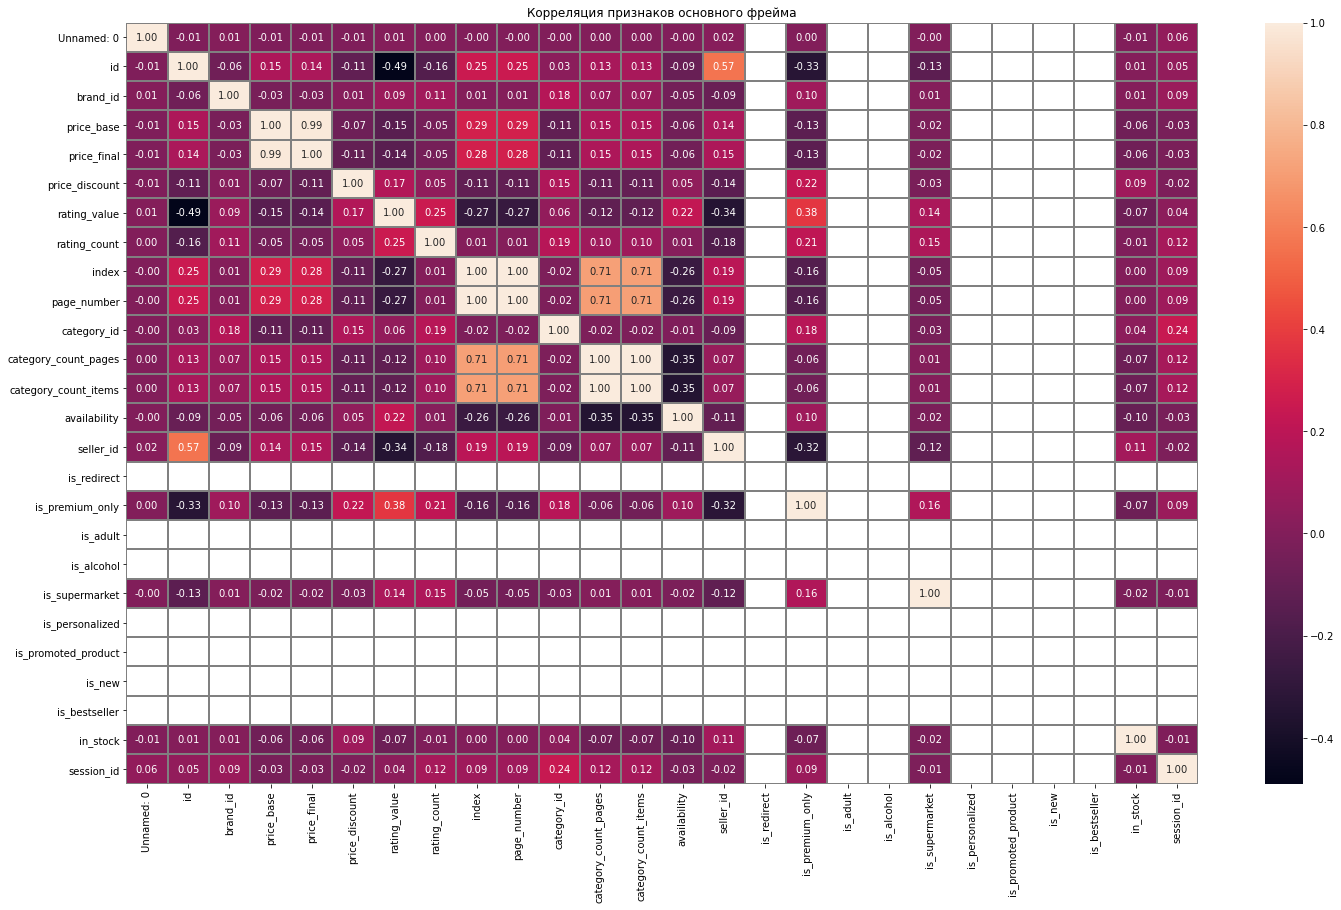

In [26]:
plt.figure(figsize=(24, 14))
plt.title('Корреляция признаков основного фрейма')
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

Как видим, показатель остатков  никак не коррелриует с другими показателями. Возможно, это связано с возвратами или отмененными заказами.

## Расчеты и исследовательский анализ 
<a id='3'></a>

In [27]:
data.head()

,time,day,hour,id,title,brand_id,brand_name,price_base,price_final,price_discount,seller_id,seller_name,in_stock
0,2021-07-27 23:03:10+03:00,27,23,285756024,Выносная GSM антенна 3 дБ SMA-male,0,NaN,450.0,450,0.00,180758,NaN,99
1,2021-07-27 13:14:12+03:00,27,13,292298787,Комплект усиления сотовой связи 3G KRD-2100,0,NaN,10500.0,10500,0.00,126128,NaN,100
2,2021-07-27 09:59:46+03:00,27,9,290716134,Wi-Fi роутер Zyxel Nbg6615,0,NaN,5802.0,5046,0.13,186373,NaN,1
3,2021-07-27 13:14:10+03:00,27,13,290716175,Wi-Fi роутер Zyxel Armor z2 nbg6817,0,NaN,22747.0,19780,0.13,186373,NaN,1
4,2021-07-27 09:59:46+03:00,27,9,290716634,Wi-Fi роутер Tenda U9,0,NaN,2579.0,2243,0.13,186373,NaN,1


### Продажи за день по каждому товару

Определим фрейм, на основании которого будем делать расчеты: просуммируем остатки по связке товар-день-бренд-продавец-цена

In [28]:
df_sales = data.groupby(['id', 'title', 'day', 'brand_name', 'seller_name', 'price_final']).agg({'in_stock': 'sum'}).reset_index().sort_values(by=['id', 'title', 'day', 'brand_name', 'seller_name', 'price_final'], ascending=True)
df_sales.head(20)

,id,title,day,brand_name,seller_name,price_final,in_stock
0,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1140,5
1,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1150,5
2,7317851,D-Link DES-1008D/RU коммутатор,15,D-Link,OZON,1150,5
3,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1140,5
4,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1150,20
5,7317851,D-Link DES-1008D/RU коммутатор,24,D-Link,OZON,1150,4
6,7317851,D-Link DES-1008D/RU коммутатор,25,D-Link,OZON,1150,4
7,7317851,D-Link DES-1008D/RU коммутатор,26,D-Link,OZON,1150,4
8,7317851,D-Link DES-1008D/RU коммутатор,27,D-Link,OZON,1150,4
9,7317851,D-Link DES-1008D/RU коммутатор,28,D-Link,OZON,1150,6


Для начала посчитаем количество остатков в предыдущий день in_stock_prev

In [29]:
df_sales['in_stock_prev'] = df_sales.groupby('id')['in_stock'].shift(1)
df_sales.head(20)

,id,title,day,brand_name,seller_name,price_final,in_stock,in_stock_prev
0,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1140,5,NaN
1,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1150,5,5.0
2,7317851,D-Link DES-1008D/RU коммутатор,15,D-Link,OZON,1150,5,5.0
3,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1140,5,5.0
4,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1150,20,5.0
5,7317851,D-Link DES-1008D/RU коммутатор,24,D-Link,OZON,1150,4,20.0
6,7317851,D-Link DES-1008D/RU коммутатор,25,D-Link,OZON,1150,4,4.0
7,7317851,D-Link DES-1008D/RU коммутатор,26,D-Link,OZON,1150,4,4.0
8,7317851,D-Link DES-1008D/RU коммутатор,27,D-Link,OZON,1150,4,4.0
9,7317851,D-Link DES-1008D/RU коммутатор,28,D-Link,OZON,1150,6,4.0


А теперь, чтобы узнать количество проданного за день товара (quant), вычтем из остатка предыдущего дня остаток текущего

In [30]:
df_sales['quant'] = df_sales['in_stock_prev'] - df_sales['in_stock']
df_sales.head(20)

,id,title,day,brand_name,seller_name,price_final,in_stock,in_stock_prev,quant
0,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1140,5,NaN,NaN
1,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1150,5,5.0,0.0
2,7317851,D-Link DES-1008D/RU коммутатор,15,D-Link,OZON,1150,5,5.0,0.0
3,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1140,5,5.0,0.0
4,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1150,20,5.0,-15.0
5,7317851,D-Link DES-1008D/RU коммутатор,24,D-Link,OZON,1150,4,20.0,16.0
6,7317851,D-Link DES-1008D/RU коммутатор,25,D-Link,OZON,1150,4,4.0,0.0
7,7317851,D-Link DES-1008D/RU коммутатор,26,D-Link,OZON,1150,4,4.0,0.0
8,7317851,D-Link DES-1008D/RU коммутатор,27,D-Link,OZON,1150,4,4.0,0.0
9,7317851,D-Link DES-1008D/RU коммутатор,28,D-Link,OZON,1150,6,4.0,-2.0


Непонятная ситуация: было бы логично, если бы количество остатков сегодня было меньше, чем вчера, или хотя бы они равны (не купили товар за день). Но видим ситуацию, когда вчерашние остатки меньше сегодняшних. И информации о дополнительных поставках м ыне видим, чтобы сложить их и получить реальные цифры. Тогда придется пожертвовать этими данными: заполним их нулями

In [31]:
df_sales['quant'] = df_sales['quant'].fillna(0)
df_sales.loc[df_sales['quant'] < 0, 'quant'] = 0
df_sales.head(20)

,id,title,day,brand_name,seller_name,price_final,in_stock,in_stock_prev,quant
0,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1140,5,NaN,0.0
1,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1150,5,5.0,0.0
2,7317851,D-Link DES-1008D/RU коммутатор,15,D-Link,OZON,1150,5,5.0,0.0
3,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1140,5,5.0,0.0
4,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1150,20,5.0,0.0
5,7317851,D-Link DES-1008D/RU коммутатор,24,D-Link,OZON,1150,4,20.0,16.0
6,7317851,D-Link DES-1008D/RU коммутатор,25,D-Link,OZON,1150,4,4.0,0.0
7,7317851,D-Link DES-1008D/RU коммутатор,26,D-Link,OZON,1150,4,4.0,0.0
8,7317851,D-Link DES-1008D/RU коммутатор,27,D-Link,OZON,1150,4,4.0,0.0
9,7317851,D-Link DES-1008D/RU коммутатор,28,D-Link,OZON,1150,6,4.0,0.0


Чтобы получить выручку по каждому товару, перемножим его цену и колиечство

In [32]:
df_sales['sales'] = df_sales['price_final'] * df_sales['quant']
df_sales.head(20)

,id,title,day,brand_name,seller_name,price_final,in_stock,in_stock_prev,quant,sales
0,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1140,5,NaN,0.0,0.0
1,7317851,D-Link DES-1008D/RU коммутатор,14,D-Link,OZON,1150,5,5.0,0.0,0.0
2,7317851,D-Link DES-1008D/RU коммутатор,15,D-Link,OZON,1150,5,5.0,0.0,0.0
3,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1140,5,5.0,0.0,0.0
4,7317851,D-Link DES-1008D/RU коммутатор,16,D-Link,OZON,1150,20,5.0,0.0,0.0
5,7317851,D-Link DES-1008D/RU коммутатор,24,D-Link,OZON,1150,4,20.0,16.0,18400.0
6,7317851,D-Link DES-1008D/RU коммутатор,25,D-Link,OZON,1150,4,4.0,0.0,0.0
7,7317851,D-Link DES-1008D/RU коммутатор,26,D-Link,OZON,1150,4,4.0,0.0,0.0
8,7317851,D-Link DES-1008D/RU коммутатор,27,D-Link,OZON,1150,4,4.0,0.0,0.0
9,7317851,D-Link DES-1008D/RU коммутатор,28,D-Link,OZON,1150,6,4.0,0.0,0.0


А теперь посчитаем и продажи каждого товара за каждый день

In [33]:
df_total = df_sales.groupby(['id', 'title', 'brand_name', 'seller_name', 'day'])['sales'].sum().reset_index()
df_total.groupby(['title', 'day'])['sales'].sum().reset_index().head(10)

,title,day,sales
0,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,1,0.0
1,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,2,0.0
2,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,3,1750000.0
3,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,4,0.0
4,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,5,0.0
5,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,6,0.0
6,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,7,0.0
7,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,8,3500000.0
8,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,9,3500000.0
9,802.11N / G / B 150 МБИТ / С RALINK 3050 БЕС...,10,0.0


### Топ 10 брендов по выручке, топ 10 продаваемых товаров

Сгруппируем товары по бренду и рассчитаем выручку по каждому из них

In [34]:
top_10_brands = (
    df_total.groupby('brand_name')['sales'].sum().reset_index()
    .sort_values(by='sales', ascending=False)
    .head(10)
    )
top_10_brands

,brand_name,sales
458,PWAY,7.943740e+09
118,COMFAST,3.553612e+09
364,MIKROTIK,2.642772e+09
141,D-Link,2.577214e+09
588,TP-Link,2.524752e+09
259,HPE,2.425588e+09
623,UBIQUITI,2.411481e+09
670,Xiaomi,2.235266e+09
639,VEGATEL,2.176493e+09
34,ASUS,2.112901e+09


Теперь визуализируем расчеты
<a id='brands'></a>

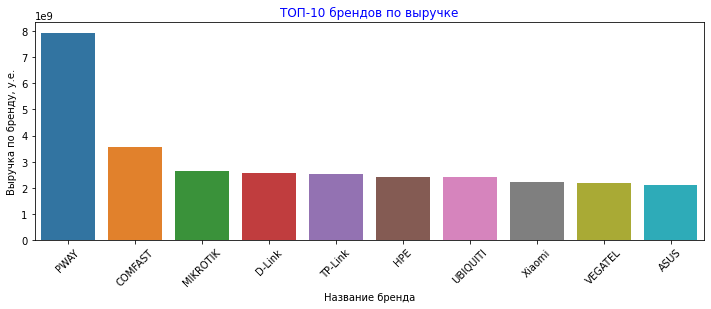

In [35]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x='brand_name', y='sales', data=top_10_brands)
plt.xticks(rotation=45)
plt.xlabel('Название бренда')
plt.ylabel('Выручка по бренду, у.е.')
plt.title('ТОП-10 брендов по выручке', color = 'blue');

Отрыв первого места от второго довольно весомый. Интересно, а что внутри самого продаваемого бренда дает максимальную выручку?

In [36]:
df_pway = (
    df_total 
    .query('brand_name == "PWAY"') 
    .groupby('title')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
    )

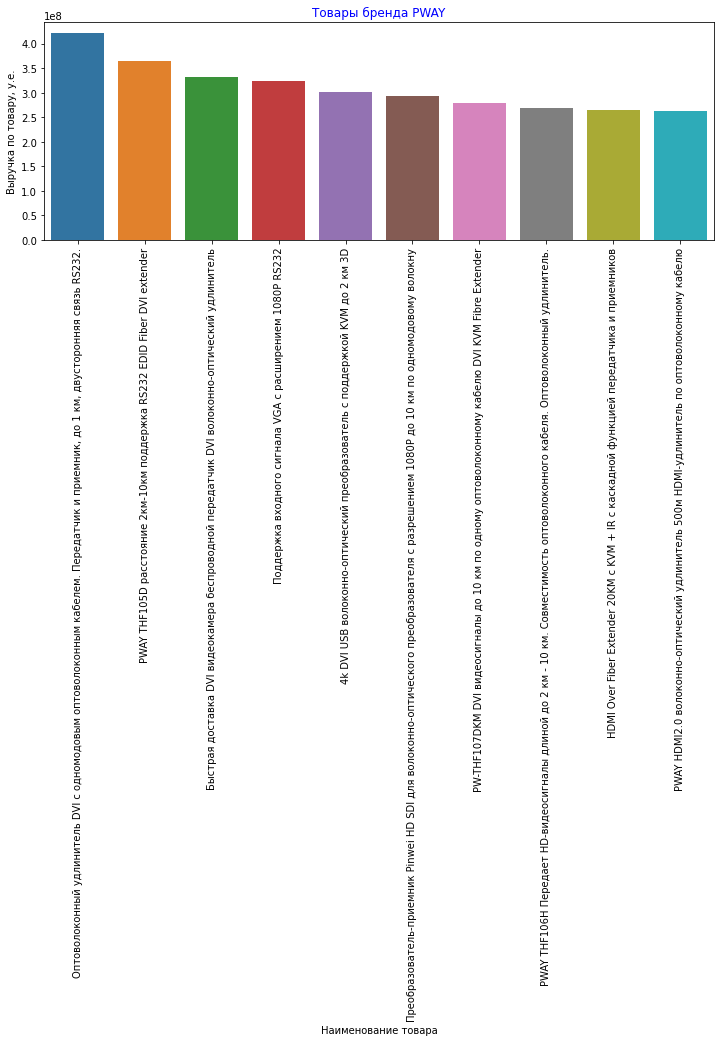

In [37]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(x='title', y='sales', data=df_pway.head(10))
plt.xticks(rotation=90)
plt.xlabel('Наименование товара')
plt.ylabel('Выручка по товару, у.е.')
plt.title('Товары бренда PWAY', color = 'blue');

Продажи разных товаров данного бренда распределены +- равномерно: сделаем вывод, что PWAY популярен и качественный

Теперь посмотрим, какие товары самые продаваемые (в количестве)

In [38]:
top_10_titles = (
    df_sales.groupby('title')['quant'].sum().reset_index()
    .sort_values(by='quant', ascending=False).head(10)
)
top_10_titles

,title,quant
4793,Адаптер CSR USB Bluetooth 4.0 блютуз,94348.0
4118,Wi-Fi роутер Xiaomi 3xLAN,67624.0
13543,Усилитель беспроводного сигнала Xiaomi Mi Wi-F...,67199.0
5022,Адаптер клавиатуры и мыши для PS4 Xbox One,58213.0
5658,Беспроводной аудио-адаптер AMAI Car Bluetooth ...,56000.0
13499,Усилитель Wi-Fi сигнала Xiaomi Mi Wi-Fi Amplif...,45817.0
9669,Мини беспроводной адаптер с внешней антенной п...,29400.0
9667,Мини беспроводной USB Bluetooth 4.0 адаптер донгл,28000.0
5619,Беспроводной WiFi ретранслятор 300 Мбит / с 80...,27002.0
4191,Wi-Fi роутер Xiaomi Mi Router 4A,26167.0


Визуализируем расчеты
<a id='quant'></a>

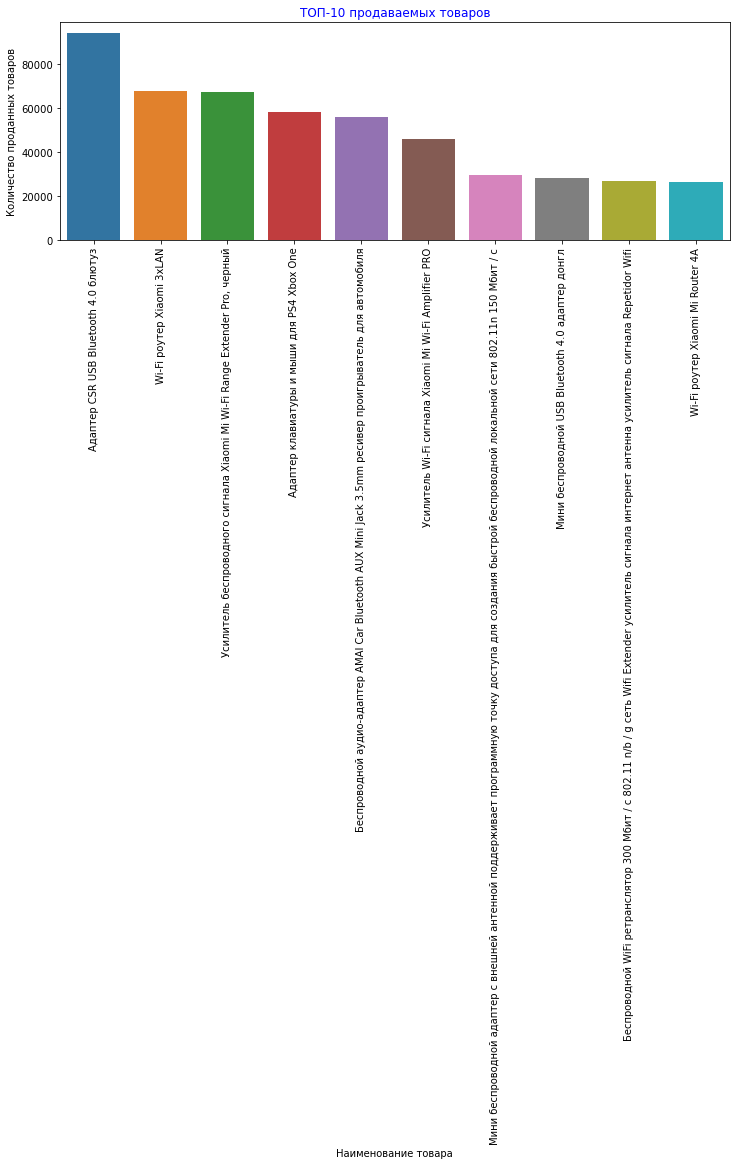

In [39]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x='title', y='quant', data=top_10_titles)
plt.xticks(rotation=90)
plt.xlabel('Наименование товара')
plt.ylabel('Количество проданных товаров')
plt.title('ТОП-10 продаваемых товаров', color = 'blue');

Реальные ли это цифры? Посмотрим на примере второго продаваемого товара - Wi-Fi роутер Xiaomi 3xLAN

In [40]:
df_sales.query('title == "Wi-Fi роутер Xiaomi 3xLAN"').sort_values(by='quant', ascending=False).head()

,id,title,day,brand_name,seller_name,price_final,in_stock,in_stock_prev,quant,sales
223225,276235128,Wi-Fi роутер Xiaomi 3xLAN,4,Xiaomi,Bblueday,7288,3500,7700.0,4200.0,30609600.0
159781,262218845,Wi-Fi роутер Xiaomi 3xLAN,28,Xiaomi,Bblueday,5986,700,4900.0,4200.0,25141200.0
283429,280882581,Wi-Fi роутер Xiaomi 3xLAN,28,Xiaomi,Aony,7580,700,4900.0,4200.0,31836000.0
159777,262218845,Wi-Fi роутер Xiaomi 3xLAN,15,Xiaomi,Bblueday,5986,1400,4900.0,3500.0,20951000.0
223237,276235128,Wi-Fi роутер Xiaomi 3xLAN,17,Xiaomi,Bblueday,7288,1400,4900.0,3500.0,25508000.0


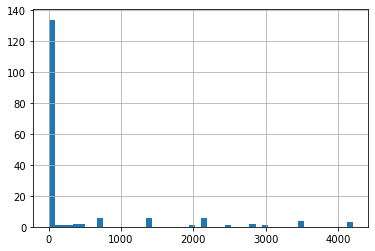

In [41]:
df_sales.query('title == "Wi-Fi роутер Xiaomi 3xLAN"')['quant'].hist(bins=50);

На первый взгляд, есть многочисленные выбросы - товары, проданные за день в количестве более 2000 штук. 
<br>
С другой стороны, на рынке существует много оптовых продавцов, а на Озоне товары заказывают люди со всего мира. 
<br>
Так что данным цифрам можно верить

### Товары, обеспечивающие 80% выручки

Чтобы узнать, какие товары обеспечивают 80% выручки, посчитаем по каждому товару выручку sales, потом - его долю perc в общей выручке и затем посчитаем накопительный итог cumsum_perc 

In [42]:
df_80_total = (
    df_total.groupby('title')['sales'].sum().reset_index()
    .sort_values(by='sales', ascending=False)
    )
df_80_total.head()

,title,sales
10035,Оптоволоконный удлинитель DVI с одномодовым оп...,421960000.0
4118,Wi-Fi роутер Xiaomi 3xLAN,417721414.0
2214,PWAY THF105D расстояние 2км-10км поддержка RS2...,364000000.0
1420,Hewlett Packard Enterprise Aruba 2930F 24G PoE...,362583621.0
8489,Коммутатор UBIQUITI US-48-500W,337295710.0


In [43]:
df_80_total['perc'] = df_80_total['sales'] / df_80_total['sales'].sum()
df_80_total.head()

,title,sales,perc
10035,Оптоволоконный удлинитель DVI с одномодовым оп...,421960000.0,0.007518
4118,Wi-Fi роутер Xiaomi 3xLAN,417721414.0,0.007443
2214,PWAY THF105D расстояние 2км-10км поддержка RS2...,364000000.0,0.006486
1420,Hewlett Packard Enterprise Aruba 2930F 24G PoE...,362583621.0,0.006460
8489,Коммутатор UBIQUITI US-48-500W,337295710.0,0.006010


In [44]:
df_80_total['cumsum_perc'] = df_80_total['perc'].cumsum()
df_80_total[df_80_total['cumsum_perc'] < 0.08]

,title,sales,perc,cumsum_perc
10035,Оптоволоконный удлинитель DVI с одномодовым оп...,421960000.0,0.007518,0.007518
4118,Wi-Fi роутер Xiaomi 3xLAN,417721414.0,0.007443,0.014961
2214,PWAY THF105D расстояние 2км-10км поддержка RS2...,364000000.0,0.006486,0.021447
1420,Hewlett Packard Enterprise Aruba 2930F 24G PoE...,362583621.0,0.006460,0.027907
8489,Коммутатор UBIQUITI US-48-500W,337295710.0,0.006010,0.033917
6472,Быстрая доставка DVI видеокамера беспроводной ...,332640000.0,0.005927,0.039843
11483,Поддержка входного сигнала VGA с расширением 1...,323680000.0,0.005767,0.045611
286,24-портовый гибридный порт 48v промышленный ис...,323680000.0,0.005767,0.051378
440,4k DVI USB волоконно-оптический преобразовател...,300720000.0,0.005358,0.056736
11495,Преобразователь-приемник Pinwei HD SDI для вол...,292320000.0,0.005208,0.061944


Визуализируем цифры
<a id='80'></a>

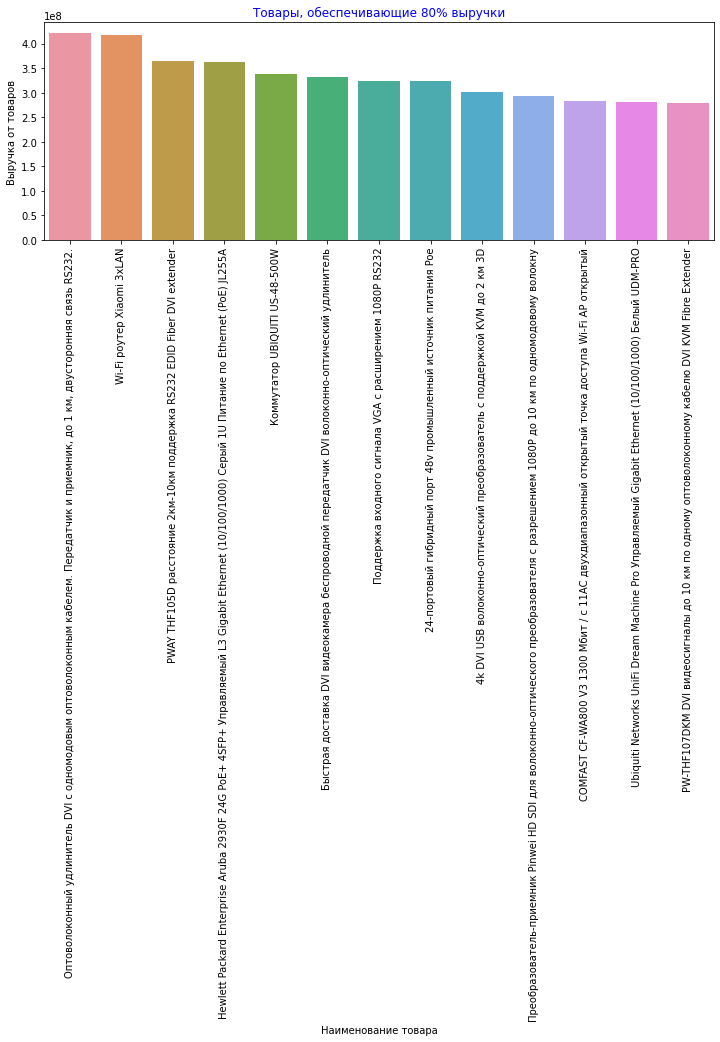

In [45]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x='title', y='sales', data=df_80_total[df_80_total['cumsum_perc'] < 0.08])
plt.xticks(rotation=90)
plt.xlabel('Наименование товара')
plt.ylabel('Выручка от товаров')
plt.title('Товары, обеспечивающие 80% выручки', color = 'blue');

### График продаж по дням

Поосчитаем продажи по каждому дню и построим соответствующий график

In [46]:
df_sales.groupby('day')['sales'].sum().reset_index().head()

,day,sales
0,1,1.672912e+08
1,2,2.586166e+09
2,3,1.363329e+09
3,4,3.317967e+09
4,5,2.791929e+09


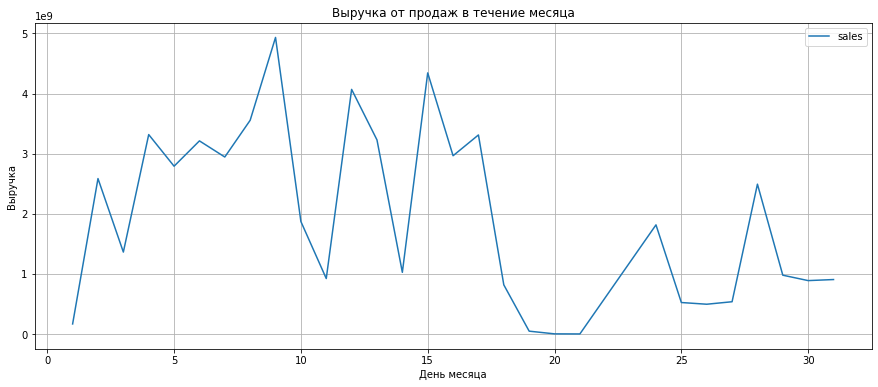

In [47]:
fig, ax = plt.subplots(figsize = (15,6))
df_sales.pivot_table(index='day', values='sales', aggfunc='sum').plot(ax=ax)
plt.xlabel('День месяца')
plt.ylabel('Выручка')
plt.title('Выручка от продаж в течение месяца')
plt.grid(True)
ax.legend(loc='upper right');


На графике заметны как пиковые значения продаж (например, 9е число), так и необъяснимый спад 21го. 
<br>
Проверим данный спад: верны ли наши расчеты?
<br>
Выберем все товары, которые продавались 21 числа

In [48]:
df_sales.query('day == 21')['sales'].sum()

1151103.0

Если мы правильно посчитали количество проданных за день товаров (с учетом разбросов остатков), то сумма должна быть реальной: просто на фоне пиковых значений в другие дни 21е число кажется минимальным

Пиковые значения, когда осуществляется очень много продаж, могут быть связаны с несколькими причинами:
- акции/скидки на озоне
- стремление юрлиц (которые являются перекупами) увеличить расходы в нужный период и, тем самым, уменьшить налогооблагаемую базу
- выход новостей о грядущем дефиците определенных изделий (люди и компании будут стремиться запастись изделиями впрок)

## Выводы
<a id='4'></a>

[ТОП брендов по выручке](#brands) с большим отрывом возглавляет бренд PWAY. За ним следуют COMFAST и MIKROTIK

В [ТОП товаров по проданному количеству](#quant) входят:
- Адаптер CSR USB Bluetooth 4.0 блютуз
- Wi-Fi роутер Xiaomi 3xLAN	
- Усилитель беспроводного сигнала Xiaomi Mi 

80% выручки обеспечивают товары по [ссылке](#80). В топе:
- Оптоволоконный удлинитель DVI
- Wi-Fi роутер Xiaomi 3xLAN	
- PWAY THF105D расстояние 2км-10км

Пиковые значения (дни, когда осуществляется очень много продаж) могут быть связаны с несколькими причинами:
- акции/скидки на озоне
- стремление юрлиц (которые являются перекупами) увеличить расходы в нужный период и, тем самым, уменьшить налогооблагаемую базу
- выход новостей о грядущем дефиците определенных изделий (люди и компании будут стремиться запастись изделиями впрок)

Думается, что расчет продаж на текущих данных можно улучшить за счет :
- склейки идентификатора бренда и его названия (brand_id, brand_name). Нам бы не пришлось делать одновременную группировку по данным двум столбцам
- аналогично - по seller_id, seller_name
- изначального пояснения по поводу остатков in_stock: думается, что отрицательные остатки не должны возникать так часто

### Общие вопросы

Пропущенные значения можно заполнить в том случае, если есть определенная закономерность - зависимость от других показателей. В данном датасете мы такую не обнаружили, чтобы заполнить пропуски в названии бренда и продавца. Сторонний пример: есть датасет с квартирами, в нем - пропуски в жилой площади. Можно рассчитать медианную площадь квартир в зависимости от количества комнат и заполнить пропуски

Несбалансированность датасета в данном случае некритична. Ведь вполне такое может быть, что одни товары популярнее других из-за банальной потребности в них. Или - как мы обозначали выше - из-за возможног грядущего дефицита и желания людей закупиться впрок

Нехватку данных можно оценивать двояко. С одной стороны, для целей нашего исследования их вполне хватало. С другой, если нам нужно спрогнозировать продажи на следующий месяц, то безусловно потребуются исторические данные (за другие периоды).